# Fine tuning of a vision model with metric learning

This notebook finetunes the ResNet18 backbone with a pair-wise loss.

### Set up

In [2]:
import pandas as pd
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torchvision.models as models
import csv
import cv2
from skimage.morphology import binary_dilation,disk
from tqdm import tqdm
warnings.filterwarnings("ignore")


### Functions definitions

In [3]:
class ImageDataset(Dataset):

    def __init__(self, folder_path, transform, max_images=None):
        self.transform = transform
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        image_list = []

        # Load by batches of images to limit RAM usage
        list_image_paths = []

        for patient in os.listdir(folder_path):
            patient_path = os.path.join(folder_path, patient)

            if os.path.isdir(patient_path):
                for file_name in os.listdir(patient_path):
                    image_path = os.path.join(patient_path, file_name)
                    list_image_paths.append(image_path)

        np.random.shuffle(list_image_paths)

        print("Number of available images:", len(list_image_paths))
        if max_images is not None and max_images < len(list_image_paths):
            list_image_paths = list_image_paths[:max_images]
        n_images = len(list_image_paths)

        print("Dataset size:", len(list_image_paths))

        # Create the image tensor
        self.image_tensor = torch.zeros((n_images, 224, 224, 3), dtype=torch.float, device="cpu")

        # Fill the tensor by batches of batch_size images
        batch_size = 32
        print("Loading images ...")
        for start_index in tqdm(range(0, n_images, batch_size)):
            end_index = min(start_index + batch_size, n_images)
            image_list = []
            for image_path in list_image_paths[start_index: end_index]:
                    image = np.array(Image.open(image_path)) / 255  # Normalize the image
                    image_list.append(image)

            self.image_tensor[start_index: end_index] = torch.tensor(np.array(image_list), dtype=torch.float, device="cpu")
            del(image_list)



    def __len__(self):
        return len(self.image_tensor)

    def __getitem__(self,i):
        """Returns a pair of batches that are distinct random transformations of the same images"""
        im_1 = self.transform(self.image_tensor[i].permute(2, 0, 1)).to(self.device)
        im_2 = self.transform(self.image_tensor[i].permute(2, 0, 1)).to(self.device)
        return im_1, im_2

In [4]:
def swap_first_half(tensor):
    """
    This function helps creating positive and negative pairs for the training
    The first two quarters of the tensor are swapped to create negative samples
    The secon half of the tensor is not modified, to create positive samples
    """
    batch_size = len(tensor)
    half_batch_size = batch_size // 2
    quarter_batch_size = batch_size // 4

    temp = torch.clone(tensor[:quarter_batch_size])
    tensor[:quarter_batch_size] = tensor[quarter_batch_size: half_batch_size]
    tensor[quarter_batch_size: half_batch_size] = temp

In [5]:
def pairwise_loss(embeddings_1, embeddings_2, same_class, m=50):
    """
    Computes the pairwise loss which penalizes the distance between positive pairs,
    and the proximity between negative pairs.

    embeddings_1 : (batch_size, embedding_dim)
    embeddings_2 : (batch_size, embedding_dim)
    same_class : (batch_size, ) of ints, 1 for positive pairs, 0 for negative pairs
    """
    dist = torch.norm(embeddings_1 - embeddings_2, dim=-1)**2
    return torch.mean(same_class * dist + torch.logical_not(same_class) * torch.clip(m - dist, min=0))

In [6]:
# Transformation to be applied during the loading of each batch
# Includes normalization and random geometric transformations
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomApply(torch.nn.ModuleList([v2.RandomRotation((90, 90))]), p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Visualize a first small batch of positive and negative pairs

Number of available images: 13453
Dataset size: 8
Loading images ...


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


<Figure size 1000x200 with 0 Axes>

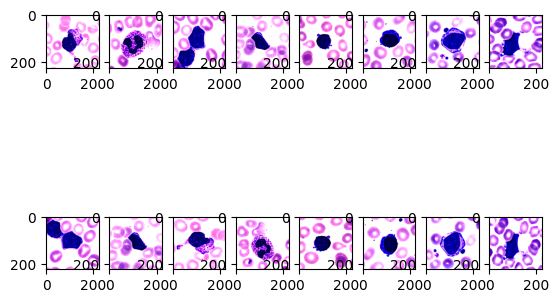

In [7]:
imgData = ImageDataset("dataset/trainset", transform, max_images=8)
len(imgData.image_tensor)
batch_size = 8

dataloader_train = DataLoader(imgData,
                              batch_size=batch_size,
                              shuffle=False)

half_batch_size = batch_size // 2
quarter_batch_size = batch_size // 4
mask = torch.ones(batch_size, requires_grad=False)
mask[:half_batch_size] = 0
for batch in dataloader_train:
    # Exchange the two first quarters of the second batch
    swap_first_half(batch[1])

    plt.figure(figsize=(10,2))
    fig, axs = plt.subplots(2,batch_size)
    for i in range(2):
        for j in range(batch_size):
            axs[i,j].imshow(batch[i][j].detach().cpu().permute(1, 2, 0).numpy())
            axs[i,j].grid(False)
    plt.show()
    break


The two lines correspond to the two versions of the batch with different transformations.
In the second line, the two first quarters of the images are swap, so that the first four pairs of images between bathes are negative, and the 4 last ones are positive.

## Pairwise loss metric learning

In [8]:
# Define device
embedding_dimension = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)

backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
model1 = torch.nn.Sequential(backbone, torch.nn.Flatten(), torch.nn.ReLU(), torch.nn.Linear(512, embedding_dimension)).to(device)

In [9]:
imgData = ImageDataset("../dataset/trainset", transform)
print("Number of images:", len(imgData.image_tensor))
batch_size = 64

dataloader_train = DataLoader(imgData,
                              batch_size=batch_size,
                              shuffle=False,
                              drop_last=True)

Number of available images: 13453
Dataset size: 13453
Loading images ...


100%|██████████| 421/421 [00:40<00:00, 10.47it/s]

Number of images: 13453


In [10]:
half_batch_size = batch_size // 2
quarter_batch_size = batch_size // 4
same_class = torch.ones(batch_size, requires_grad=False, device=device)
same_class[:half_batch_size] = 0

m = 10 # 50

optim = torch.optim.Adam(model1.parameters())

epochs = 3

losses = []

for e in range(epochs):
  print("Start epoch", e)

  for batch in tqdm(dataloader_train):
      # Exchange the two first quarters of the second batch
      optim.zero_grad()
      swap_first_half(batch[1])
      embeddings_A = model1(batch[0])
      embeddings_B = model1(batch[1])

      loss = pairwise_loss(embeddings_A, embeddings_B, same_class, m=m)
      loss.backward()
      optim.step()

      losses.append(loss.detach().cpu().numpy())
  print(np.mean(losses[-len(imgData)//batch_size:]))


Start epoch 0


100%|██████████| 210/210 [02:36<00:00,  1.34it/s]


0.62701607
Start epoch 1


100%|██████████| 210/210 [02:32<00:00,  1.37it/s]


0.35625714
Start epoch 2


100%|██████████| 210/210 [02:42<00:00,  1.29it/s]

0.28419328


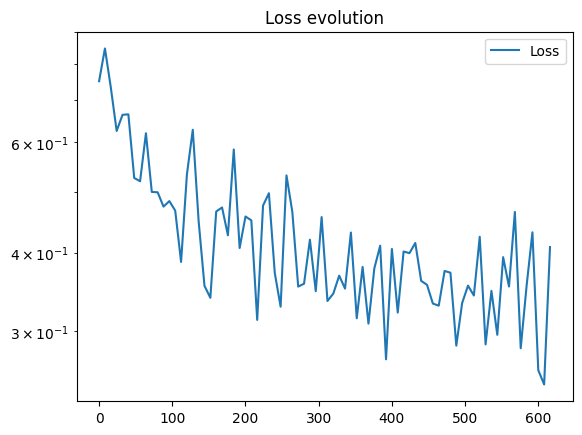

In [20]:
downsampling = 8 # To smooth the loss evolution plot
troncated_losses = losses[:downsampling*(len(losses) // downsampling)]
smoothed_losses = np.array(troncated_losses).reshape(downsampling, -1)
smoothed_losses = np.mean(smoothed_losses, axis=0)

plt.plot(np.arange(len(smoothed_losses)) * downsampling, smoothed_losses, label="Loss")
plt.legend()
plt.title("Loss evolution")
plt.yscale('log')
plt.show()

In [12]:
torch.save(model1, "FinetunedResNet_dim_"+str(embedding_dimension)+"_m_"+str(10))

## Plot the distances between some positive and negative pairs

In [13]:
for batch in dataloader_train:
      # Exchange the two first quarters of the second batch
      swap_first_half(batch[1])
      embeddings_A = model1(batch[0])
      embeddings_B = model1(batch[1])
      break

dist = torch.norm(embeddings_A - embeddings_B, dim=-1)**2
loss_element = same_class * dist + torch.logical_not(same_class) * torch.clip(m - dist, min=0)

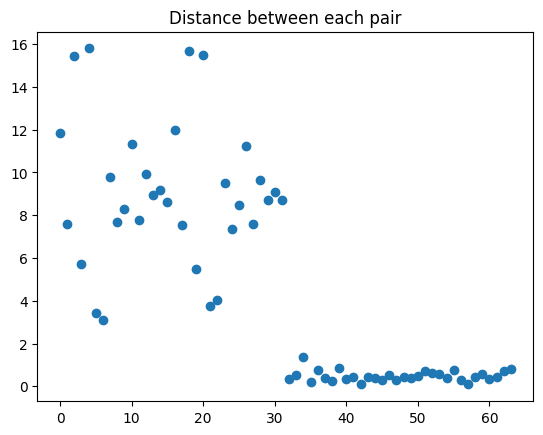

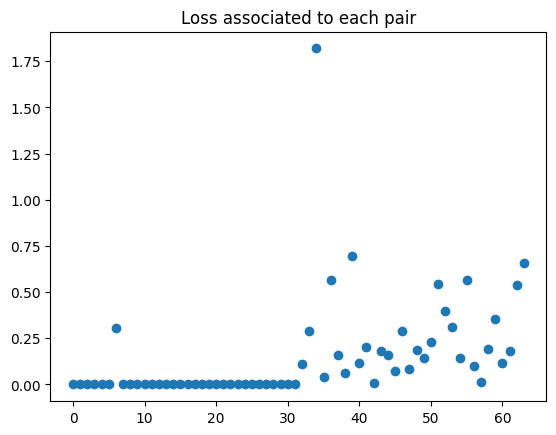

In [14]:
dist_np = dist.detach().cpu().numpy()
loss_element_np = loss_element.detach().cpu().numpy()
plt.scatter(range(batch_size), np.sqrt(dist_np))
plt.title("Distance between each pair")
plt.show()
plt.scatter(range(batch_size), loss_element_np)
plt.title("Loss associated to each pair")
plt.show()

On the two plots above, the first half of the points are negative pairs, and the second half corresponds to positive pairs.
We observe that the distance between negative pairs is higher than between positive pairs, and is most of the time above the threshold distance $m$, thus most of the loss is due to the positive samples.